<a href="https://colab.research.google.com/github/kode-git/FER-Visual-Transformers/blob/main/Data_Integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Integration

ViT Face Emotion Recognition is a project based on the use of transformers for image classification. Our project demonstrated that transformers could classify some images in tasks like emotion recognition. The project has three different datasets in input that must merge into one homogeneous dataset. Firstly, we need to resize images using a 224x224 total dimension because transformers have the same linear size for the input and the patching phase needs the same amount of data. The result subsets must merge on one dataset called ViT. 

ViT Dataset has eight different classes integrated by three different subsets:
1. FER-2013: Fer2013 contains approximately 30,000 facial RGB images of different expressions with a size restricted to 48×48, and the main labels can be split into seven types: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral. The Disgust expression has a minimal number of images – 600, while other labels have nearly 5,000 samples each.
2. CK+: The Extended Cohn-Kanade (CK+) dataset contains images extrapolated from 593 video sequences from 123 different subjects, ranging from 18 to 50 years of age with a variety of genders and heritage. Each video shows a facial shift from the neutral expression to a targeted peak expression, recorded at 30 frames per second (FPS) with a resolution of either 640x490 or 640x480 pixels. Unfortunately, we do not have all generated datasets, but we stored only 1000 images with high variance from a Kaggle repository. 
3. AffectNet: It is a sizeable facial expression dataset with 40k images classified in eight categories (neutral, happy, angry, sad, fear, surprise, disgust, contempt) of facial expressions along with the intensity of valence and arousal.

Each dataset focuses on RGB channels for the colouring and has different sizes and image extensions entirely stored in Google Drive (the total amount of data is around 2 GB). So, we need to establish a standard format to manage them simultaneously. Finally, we will pass in a data augmentation phase to improve the total amount of images to balance the number of samples for each category. 

Finally, we have the final sections interested in the fine-tuning phase and training on a few models that can be saved locally on the drive and used in an external application for real-time classification on an ad-hoc application. More information about modelling is in the following sections.

## Install Dependencies and Import Libraries

In [ ]:
!pip3 install Pillow
!pip install pandas

In [4]:
# classic libraries for collections.
import pandas as pd
import numpy as np

# utility library.
import random, time, copy

# plot libraries.
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# libraries for image processing .
import os, cv2, glob, imageio, sys
from PIL import Image

# warning library for service warnings.
import warnings

# Google Colab library.
from google.colab import drive

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


## Image Worker Implementation

ImageWorker provides some useful functions:
- Format Converter: For resize and move an image from *source_path* to *dest_path* filtered for *format_img*
- List Classes: Listing the classes and put them in an array to manipulate the subfolders for class functions divisions.
- Counter Samples per Class: Given a *dataset_path*, return a dictionary with counters of images classified by subfolders for plot or data visualization pourposes. 
- Counter Samples: Given a *dataset_path*, return a counter of images in the tree.
- Extension Converter: Convert an image format for every image in a specified path
- Counter Files Extension: Given a *path*, return the counter of image in the directory with a specific *format*
- Navigate Path: Counter every file in a subtree

In [6]:
class ImageWorker():
    """
    Image Worker class for Data Integration.
    This class manages images data, size and format.
    """
    def __init__(self) -> None:
         pass

    def format_converter(self, path, format_img, source_path, dest_path, resize=(224,224)):
        """
        Move an image from source_path to dest_path.
        Images selected follow format_img.
        There is a default resize of (224,244).
        """
        count = 0
        for file in glob.glob(path + "/*." + format_img):
            img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
            resized = cv2.resize(img, resize, interpolation=cv2.INTER_CUBIC)
            cv2.imwrite(dest_path + "resized_on_" + source_path + "_" + str(count) + "."+ format_img, resized)
            count += 1

    def list_classes(self, dataset_path):
        """
        List the classes of a dataset.
        """
        langs = []
        for el in glob.glob(dataset_path):
          langs.append(os.path.basename(str(el)))
        return langs


    def counter_samples_on_class(self, dataset_path):
      """
      Counts samples of classes.
      Each class has its own counter.
      Return a dictionary with (class, counter) pair.
      """
      classes = self.list_classes(dataset_path)
      counter_classes = {}
      if dataset_path[len(dataset_path) - 1] == "/":
          path = dataset_path
      if dataset_path[len(dataset_path) - 1] == "*":
          path = dataset_path[0:len(dataset_path) - 2] + "/"
      else:
          path = dataset_path + "/"
      for class_ in classes:
        counter = 0
        for file in glob.glob(path + class_ + "/*"):
            counter += 1
        counter_classes[class_] = counter
      return counter_classes


    def counter_samples(self, dataset_path):
      """
      Counts total samples of a dataset.
      """
      a = self.counter_samples_on_class(dataset_path)
      counter = 0
      for el in a.keys():
        counter += a[el]
      return counter


    def extension_converter(self, path, format_source, format_result, dest_path):   
      """
      Convert a file from format_source to format_result.
      The file is loaded from path and the result is stored to dest_path.
      """
      for file in glob.glob(path + "/*." + format_source):
          im1 = Image.open(file)
          im1.save(file[0:len(file)-4] + "." + format_result)
          os.remove(file)


    def counter_file_extension(self, path, format):
      """
      Counts samples in path based on format input.
      """
      counter = 0
      for file in glob.glob(path + "/*." + format):
          counter += 1
      return counter
      

    def navigate_path(self, path):    
      """
      Navigate in the path and counts every file
      """
      count = 0
      for dir in os.listdir(path):
          if os.path.isfile(os.path.join(path, dir)):
              count += 1
      return count

In [7]:
# Instance of Image Worker for the notebook.
iw = ImageWorker()

## Common utilities

We implemented some logic and reusable functions useful for the data analysis or data manipulation phases. These functions carry out support routines for ImageWorker's class. They are:
- Min, Max and Mean: According to values or set of values passed as parameter.
- Plot Dataset: Function for plot image's dataset and color values according to the mean of classes cardinalities.
- Channel Distribution: Analyze images and return counters of images for different channels dimension.

In [9]:
def mean(values):
  """
  Calculates the mean in values.
  """
  if len(values) <= 0:
    return 0
  else:
    sum = 0
    for el in values:
      sum += el
    return int(sum / len(values))

def min(val):
  """
  Calculates the minimum in val.
  """
  min = sys.maxsize
  for el in val.keys():
    if val[el] < min:
      min = val[el]
  return min


def max(val):
  """
  Calculates the maximum in val.
  """
  max = sys.minsize
  for el in val.keys():
    if val[el] > max:
      max = val[el]
  return max


def plot_dataset(dataset_path, title=""):
  """
  Plot the dataset and color bars.
  Color depends on the lower bound and upper bound.
  The mean value is the congiuntion between lower and upper bound.
  """
  classes = iw.list_classes(dataset_path)
  l_classes = iw.counter_samples_on_class(dataset_path)

  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1,])
  x = [l_classes[class_] for class_ in classes]
  y = [class_ for class_ in classes]
  
  colors = []
  x_cap = mean(x)

  # colors identify when the elements are greater or lesser than the mean values.
  for el in x:
    if el < x_cap:
      colors.append("#BC3434")
    else:
      colors.append("#49A131")
  ax.bar(y, x, color=colors)
  plt.title(title)
  plt.show()



def channels_distribution(dataset_path):
  """
  Lists the channels dimensions of an image and return list of counters.
  The indeces of the list are the numbers of channels.
  The values are the number of files with a specific 
  number of channels corresponding to the index.
  """
  chan_size = [0 for i in range(0, 5)]
  for path in glob.glob(dataset_path):
    for el in os.listdir(path):
       pic = imageio.imread(path + "/" + el)
       chan_size[pic.ndim] += 1
  return chan_size

## Data Merging

In this section, we will provides partial data analysis related to data sources corresponding to subsets of images of the final dataset. Furthermore, we carry out the data merging in a temporal dataset located in AVFER folder. We will make the structure of this dataset with the creation of foldels corresponding to labels for the final loading. 

In [ ]:
!mkdir /content/drive/MyDrive/Datasets/AVFER/
!mkdir /content/drive/MyDrive/Datasets/AVFER/train
!mkdir /content/drive/MyDrive/Datasets/AVFER/val
!mkdir /content/drive/MyDrive/Datasets/AVFER/test

In [ ]:
base_dir = "/content/drive/MyDrive/Datasets/AVFER/"
x = "/content/drive/MyDrive/Datasets/AffectNet/train_class/"
subfolders = [el for el in os.listdir(base_dir)]
classes = [cl for cl in os.listdir(x)]

for cl in classes:
  for folder in subfolders:
    os.mkdir(base_dir  + folder + "/" + cl)

### Merging FER-2013

FER-2013 is a dataset composed of 35.953 images in 7 classes (fear, disgust, sad, happy, neutral, surprise, angry). Images are in size 48x48 with a grey-scaled colours palette. The classes' variations and features distributions are helpful in the merging phase for other classes to obtain a good distribution and normalize the amount of data variation. According to the final classification, the contempt class was missed on this kind of dataset.

In [10]:
# Dataset specifics.
num_classes = 7
data_train_fer = '/content/drive/My Drive/Datasets/FER-2013/train/*'
data_val_fer = '/content/drive/My Drive/Datasets/FER-2013/val/*'
fer_classes_t = iw.list_classes(data_train_fer)
fer_classes_v = iw.list_classes(data_val_fer)

Classes: ['happy', 'fear', 'sad', 'disgust', 'surprise', 'neutral', 'anger']
Total no. of images in FER:  35953
Total no. of train images in FER: 28775
Total no. of val images in FER: 7178
----------------------------------------


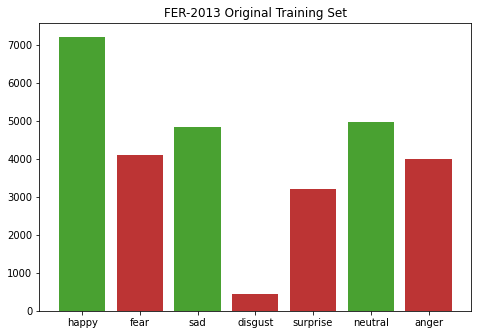

In [12]:
fer_train_tot = iw.counter_samples(data_train_fer)
fer_val_tot = iw.counter_samples(data_val_fer)
fer_tot = fer_train_tot + fer_val_tot
print('Classes:', fer_classes_t)
print("Total no. of images in FER: ", fer_tot)
print("Total no. of train images in FER:", fer_train_tot)
print("Total no. of val images in FER:", fer_val_tot)
print('-'*40)
plot_dataset(data_train_fer, title="FER-2013 Original Training Set")

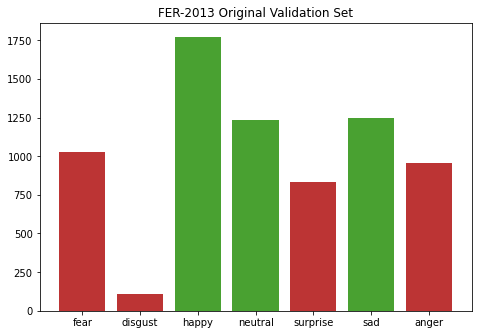

In [13]:
plot_dataset(data_val_fer, title="FER-2013 Original Validation Set")

FER-2013 do not have many samples for the disgust class. This observation guarantees an excellent motivation to merge it with other datasets and the data augmentation phase. Furthermore, it is unbalanced, and we need to manage it in data augmentation or data integration with some samples from other datasets to make a result set with the same number of samples for each class.

70


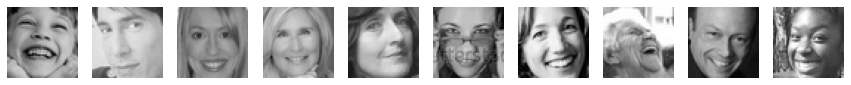

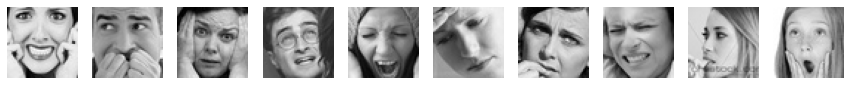

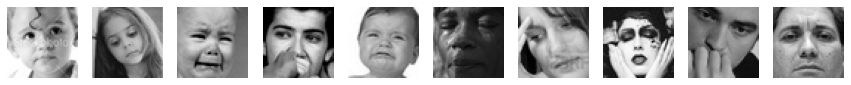

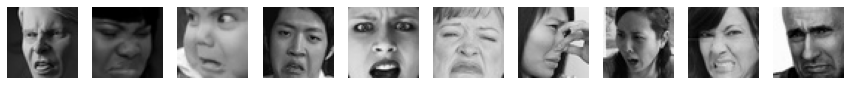

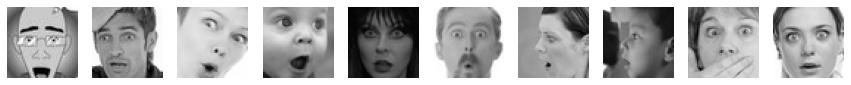

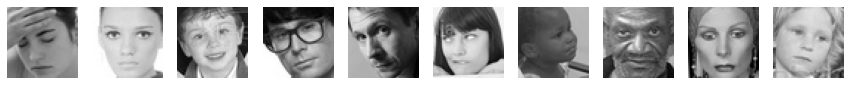

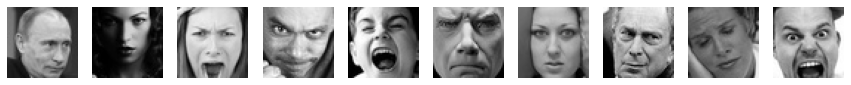

In [14]:
# taking files from training classes.
paths = []
for path in glob.glob("/content/drive/MyDrive/Datasets/FER-2013/train/*"):
  paths.append(path + "/*.jpg")

# put in the results the images.
results = []
for path in paths:
  counter = 0
  for file in glob.glob(path):
    if counter < 10:
      results.append(cv2.imread(file))
      counter += 1
    else: 
      break

# print the final grid.
print(len(results))
for j in range(0, num_classes):
  fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))
  for i in range(0,10):
    ax[i].imshow(cv2.cvtColor(results[i+j*10], cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

This dataset is pretty good in terms of data views, with some variance in the patterns given by a significant variability of facial expressions for each category. The image size is 48x48; we need to resize it to 224x224 size and put it together in the same folder as the other datasets for data integration. We will use our ImageWorker object to do that.

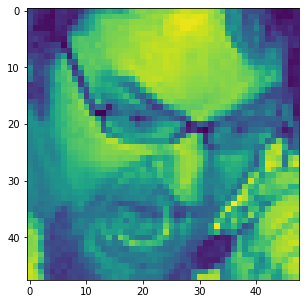

In [15]:
# take a sample from the dataset.
sample_img = '/content/drive/MyDrive/Datasets/FER-2013/val/anger/PrivateTest_10131363.jpg'
pic = imageio.imread(sample_img)
plt.figure(figsize = (5,5))
plt.imshow(pic)

In [17]:
# metadata analysis.
print('Type of the image : ' , type(pic)) 
print('Shape of the image : {}'.format(pic.shape)) 
print('Dimension of Image: {}'.format(pic.ndim))
print('Image size: {}'.format(pic.size)) 
print('Maximum channel value in this image: {}'.format(pic.max())) 
print('Minimum channel value in this image: {}'.format(pic.min()))

Type of the image :  <class 'imageio.core.util.Array'>
Shape of the image : (48, 48)
Dimension of Image: 2
Image size: 2304
Maximum channel value in this image: 229
Minimum channel value in this image: 3


We need to check if there are any images in the dataset with different shapes and color dimensions.

In [ ]:
# takes the channels distribution for the original training and validation set.
train_ch = channels_distribution(data_train_fer)
val_ch = channels_distribution(data_val_fer)

# unify the two distribution in one list.
if len(train_ch) == len(val_ch):
  tot_ch = [0 for i in range(len(train_ch))]
  for i in range(0, len(train_ch)):
     tot_ch[i] = train_ch[i] + val_ch[i]

# display the result.
print('Total channels distribution :', tot_ch)

Given expected output, we can merge training and validation subfolders in the final dataset with a regular size of 224 x 224

In [ ]:
# Resize FER-2013 training images in 224x224 and put the result in the final dataset.
format_fer = "jpg"
source_type = "fer_2013"

# create directories for sources and destinations.
destinations = ["/content/drive/MyDrive/Datasets/AVFER/train/" + class_ + "/" for class_ in fer_classes_t]
sources = ["/content/drive/MyDrive/Datasets/FER-2013/train/" + class_ for class_ in fer_classes_t]

# resize and moves images with format_fer.
for i in range(0,len(destinations)):
  iw.format_converter(sources[i], format_fer, source_type, destinations[i])

The data integration phase did not distinguish between train and test splitting. So, we can merge the FER-2013 val set with the training set and split it a second time. Our interest is to analyze the val set as well as we did with the training set.

In [ ]:
# Resize FER-2013 validation images in 224x224 and put the result in the final dataset.

# create directories for sources, destinationsa are the same of the previous snippet.
sources = ["/content/drive/MyDrive/Datasets/FER-2013/val/" + class_ + "/" for class_ in fer_classes_t]
source_type = "fer_2013_test"

# resize and moves images with format_fer.
for i in range(0, len(destinations)):
  iw.format_converter(sources[i], format_fer, source_type, destinations[i])

### Merging CK+48

It is a small dataset composed of 981 images in seven classes (fear, disgust, sad, happy, neutral, surprise, angry). Images are in size 48x48 with a grey-scaled colours palette. The classes' variations and features distributions are helpful in the merging phase for other classes to obtain a good distribution and normalize the amount of data variation. 

In [18]:
# dataset specifics.
num_classes = 7
data_dir_ck = '/content/drive/My Drive/Datasets/CK+48/*'
ck_classes_t = iw.list_classes(data_dir_ck)
ck_tot = iw.counter_samples(data_dir_ck)
print('Classes:', ck_classes_t)
print("Total no. of images in CK+: ", ck_tot)

Classes: ['fear', 'sadness', 'happy', 'anger', 'disgust', 'contempt', 'surprise']
Total no. of images in CK+:  986


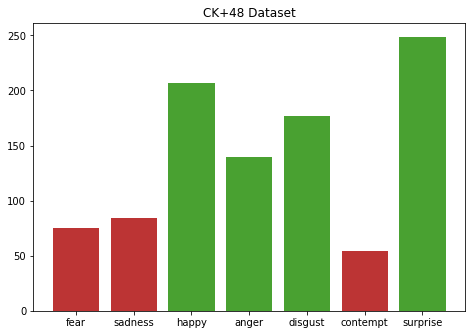

In [19]:
plot_dataset("/content/drive/MyDrive/Datasets/CK+48/*", title="CK+48 Dataset")

7
70


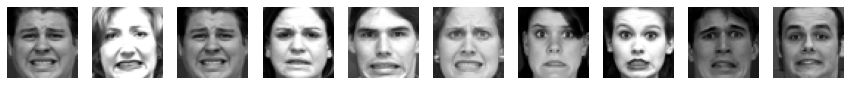

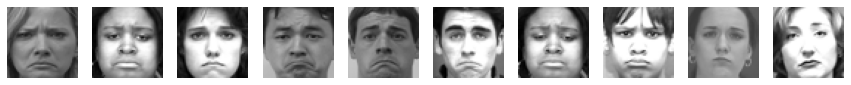

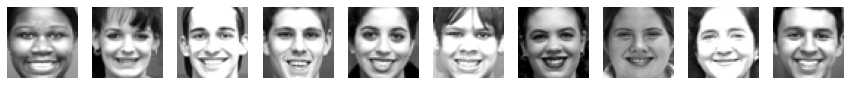

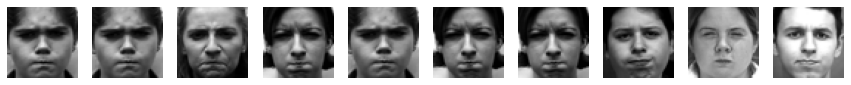

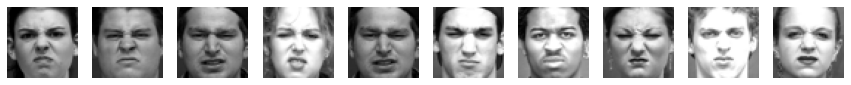

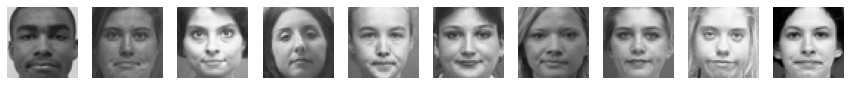

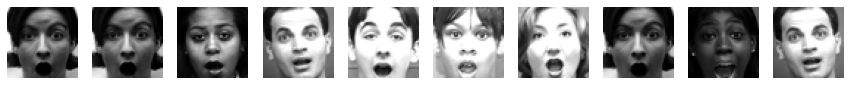

In [20]:
# collections of files from the dataset.
paths = []
for path in glob.glob(data_dir_ck):
  paths.append(path + "/*.png")

# read files and add the result in the list.
results = []
num_classes = len(ck_classes_t)
print(num_classes)
for path in paths:
  counter = 0
  for file in glob.glob(path):
    if counter < 10:
      results.append(cv2.imread(file))
      counter += 1
    else: 
      break

# display images in the grid.
print(len(results))
for j in range(0, num_classes):
  fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))
  for i in range(0,10):
    ax[i].imshow(cv2.cvtColor(results[i+j*10], cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

The image size is 48x48. To retrieve some data in a standard format, we will try to resize them, maintaining pixels patterns for data processing. The new size is 224x224, which should maintain in a good way features of the samples. We will save the resized images in a new folder on the drive.

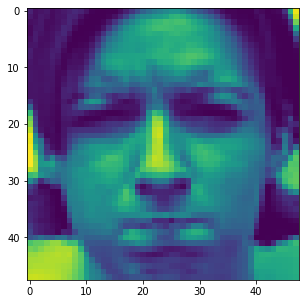

In [21]:
# Read a sample from CK+48.
sample_img = '/content/drive/MyDrive/Datasets/CK+48/anger/Copia di S010_004_00000017.png'
pic = imageio.imread(sample_img)
plt.figure(figsize = (5,5))
plt.imshow(pic)

In [24]:
# metadata analysis.
print('Type of the image : ' , type(pic)) 
print('Shape of the image : {}'.format(pic.shape)) 
print('Dimension of Image: {}'.format(pic.ndim))
print('Image size: {}'.format(pic.size)) 
print('Maximum channel value in this image: {}'.format(pic.max())) 
print('Minimum channel value in this image: {}'.format(pic.min()))
print('Total channels distribution :', channels_distribution(data_dir_ck))

Type of the image :  <class 'imageio.core.util.Array'>
Shape of the image : (48, 48)
Dimension of Image: 2
Image size: 2304
Maximum channel value in this image: 255
Minimum channel value in this image: 0
Total channels distribution : [0, 0, 986, 0, 0]


In [ ]:
# Resize images and put the result in the final dataset
format_ck = "png"
source_type = "ck_plus"

# defines sources and destinations paths.
destinations = ["/content/drive/MyDrive/Datasets/AVFER/train/" + class_ + "/" for class_ in ck_classes_t]
sources = ["/content/drive/MyDrive/Datasets/CK+48/" + class_ for class_ in ck_classes_t]

# resize images from paths and store the result on destinations.
for i in range(0,len(destinations)):
  iw.format_converter(sources[i], format_ck, source_type, destinations[i])

### Merging AffectNet

AffectNet dataset has samples of different sizes, high-quality images in grey-scale or coloured in RGB range. It has eight different classes (surprise, angry, sad, contempt, disgust, fear, neutral, and happy). As the FER-2013, there is a division between validation and training set; however, we will no merge it as well as we did with FER subsets, but put the validation set in the final val folder. Furthermore, we resize the different sizes of its images in 224x224 to establish the same amount of pixels for each sample.

In [25]:
# dataset specifics.
num_classes = 8
data_train_af = '/content/drive/My Drive/Datasets/AffectNet/train_class/*'
data_val_af = '/content/drive/My Drive/Datasets/AffectNet/val_class/*'
af_classes_t = iw.list_classes(data_train_af)
af_classes_v = iw.list_classes(data_val_af)

Classes: ['happy', 'surprise', 'neutral', 'fear', 'disgust', 'contempt', 'anger', 'sad']
Total no. of images in AffectNet:  41591
Total no. of train images in AffectNet: 37591
Total no. of val images in AffectNet: 4000
----------------------------------------


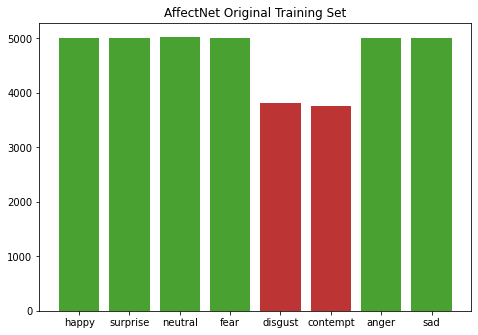

In [26]:
# print dataset features.
af_train_tot = iw.counter_samples(data_train_af)
af_val_tot = iw.counter_samples(data_val_af)
af_tot = af_train_tot + af_val_tot
print('Classes:', af_classes_t)
print("Total no. of images in AffectNet: ", af_tot)
print("Total no. of train images in AffectNet:", af_train_tot)
print("Total no. of val images in AffectNet:", af_val_tot)
print('-'*40)
plot_dataset(data_train_af, title="AffectNet Original Training Set" )

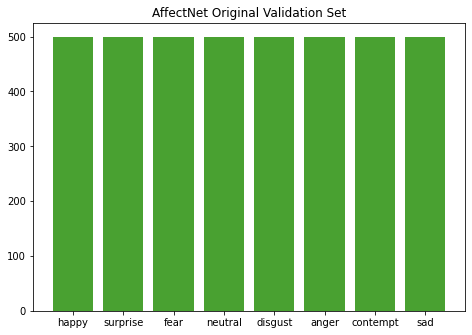

In [27]:
plot_dataset(data_val_af, title="AffectNet Original Validation Set")

8
80


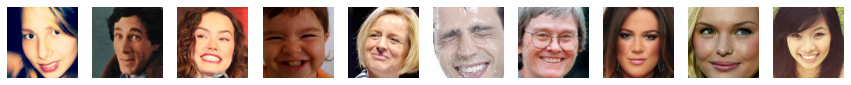

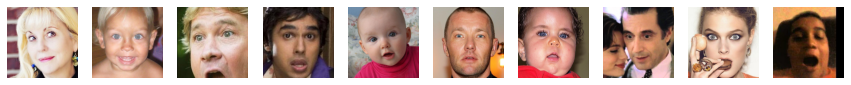

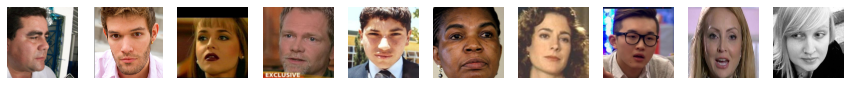

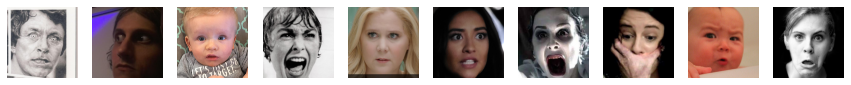

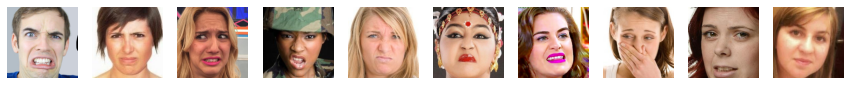

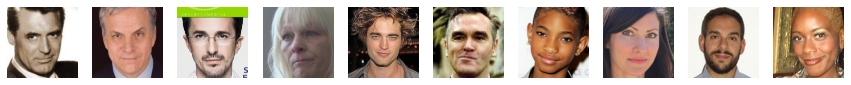

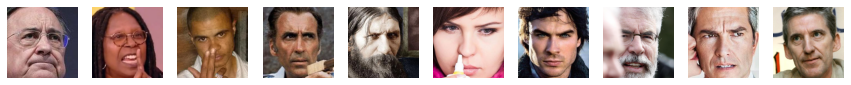

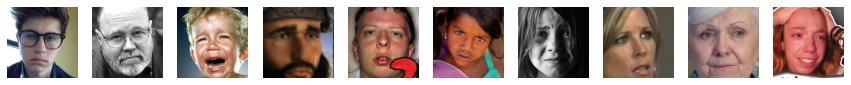

In [28]:
# list the paths of the dataset files.
paths = []
for path in glob.glob(data_train_af):
  paths.append(path + "/*.jpg")

# read images and put in the results list.
results = []
num_classes = len(af_classes_t)
print(num_classes)
for path in paths:
  counter = 0
  for file in glob.glob(path):
    if counter < 10:
      results.append(cv2.imread(file))
      counter += 1
    else: 
      break

# display images in the grid.
print(len(results))
for j in range(0, num_classes):
  fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))
  for i in range(0,10):
    ax[i].imshow(cv2.cvtColor(results[i+j*10], cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

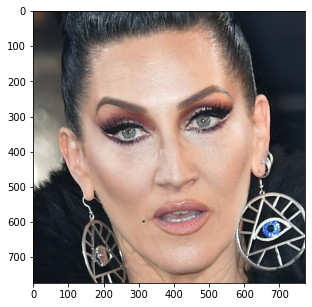

In [29]:
# load samples from AffectNet.
sample_affectnet = '/content/drive/MyDrive/Datasets/AffectNet/train_class/anger/Copia di image0000006.jpg'
pic = imageio.imread(sample_affectnet)
plt.figure(figsize = (5,5))
plt.imshow(pic)

Type of the image :  <class 'imageio.core.util.Array'>
Shape of the image : (773, 773, 3)
Image Hight 773
Image Width 773
Dimension of Image 3
Image size 1792587
Maximum RGB value in this image 255
Minimum RGB value in this image 0
----------------------------------------
Value of only R channel 224
Value of only G channel 196
Value of only B channel 184
---------------------------------------------------------------------------------------------------------


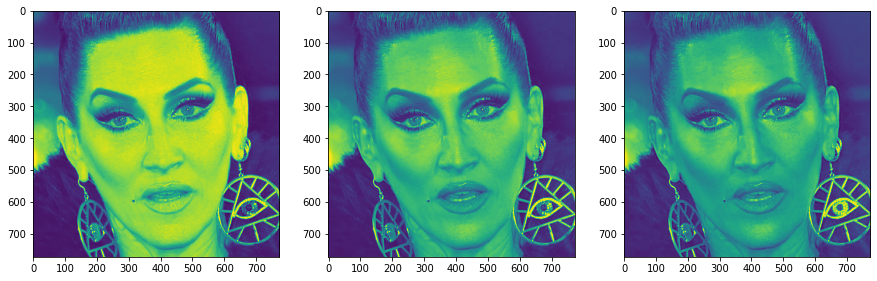

In [35]:
# metadata analysis.
print('Type of the image : ' , type(pic)) 
print('Shape of the image : {}'.format(pic.shape)) 
print('Image Hight {}'.format(pic.shape[0])) 
print('Image Width {}'.format(pic.shape[1])) 
print('Dimension of Image {}'.format(pic.ndim))
print('Image size {}'.format(pic.size)) 
print('Maximum RGB value in this image {}'.format(pic.max())) 
print('Minimum RGB value in this image {}'.format(pic.min()))
print('-'*40)
print('Value of only R channel {}'.format(pic[387, 387, 0])) 
print('Value of only G channel {}'.format(pic[387, 387, 1])) 
print('Value of only B channel {}'.format(pic[387, 387, 2]))
print('-'*105)
# display pixels with singular channel value.
fig, ax = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))  
for c, ax in zip(range(3), ax):     
    ax.imshow(pic[ :, :, c])

Now, we know that each pixel of the image is represented by three integers. Splitting the image into separate color components is just a matter of pulling out the correct slice of the image array. So, we can use the zero matrix generated by the original version given by the zero function from numpy library.

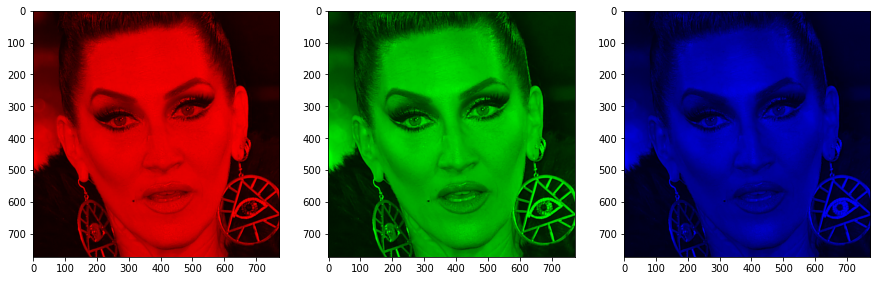

In [36]:
# display the same pixels on a zero matrix.
pic = imageio.imread(sample_affectnet) 
fig, ax = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))  
for c, ax in zip(range(3), ax):         
     split_img = np.zeros(pic.shape, dtype="uint8") # make a zero matrix.
     split_img[ :, :, c] = pic[ :, :, c] # visualize one of the 3 channel.
     ax.imshow(split_img)

In [ ]:
# checking channels distribution on AffectNet samples.
train_ch = channels_distribution(data_train_af)
val_ch = channels_distribution(data_val_af)

if len(train_ch) == len(val_ch):
  tot_ch = [0 for i in range(len(train_ch))]
  for i in range(0, len(train_ch)):
     tot_ch[i] = train_ch[i] + val_ch[i]

print('Total channels distribution :', tot_ch)

In [ ]:
# format of the image in the AffectNet.
format_affectnet = "jpg"
# the name tag.
source_type = "affect_net"

# We pass the AffectNet dataset in the validation set to balance it in the validation and testing subset.
# Given a size bigger than CK+48 and FER-2013, we can use only a part in training and mantains the 
# rest in the testing and validation (only a small part related to the training set).
destinations = ["/content/drive/MyDrive/Datasets/AVFER/val/" + class_ + "/" for class_ in af_classes_t]
sources = ["/content/drive/MyDrive/Datasets/AffectNet/train_class/" + class_ + "/" for class_ in af_classes_t]

# moves and resize AffectNet training samples.
for i in range(0,len(destinations)):
  iw.format_converter(sources[i], format_affectnet, source_type, destinations[i])

In [ ]:
# the name tag.
source_type = "affect_net_2"

# list destinations and sources, we put it on the validation set of the result dataset.
destinations = ["/content/drive/MyDrive/Datasets/AVFER/test/" + class_ + "/" for class_ in af_classes_t]
sources = ["/content/drive/MyDrive/Datasets/AffectNet/val_class/" + class_ for class_ in af_classes_t]

# moves and resize AffectNet validation samples.
for i in range(0,len(destinations)):
  iw.format_converter(sources[i], format_affectnet, source_type, destinations[i])

## Result of Integration

AVFER is a ViT dataset where the validation set is composed only by images from the AffectNet dataset. The testing set is composed to these kind of image too to mantain a correct verification of the model performances. Furthermore, the training set is composed even by FER-2013 and CK+48 datasets. 

In [ ]:
# specifics of AVFER.
num_classes = 8
data_avfer = []
base_directory = "/content/drive/My Drive/Datasets/AVFER/*"
sets = iw.list_classes(base_directory)
i = 0

# display the subset division.
print('Division of AVFER: ')
for subset in sets:
  data_avfer.append('/content/drive/My Drive/Datasets/AVFER/' + subset + '/*')
  print(data_avfer[i])
  i = i + 1

In [ ]:
# counts of the subsets samples and total number.
avfer_tot = 0
i = 0
total = 0
for i in range(3):
  base_directory = data_avfer[i][:len(data_avfer[i])-1]
  counter_folder = 0
  for cl in os.listdir(base_directory):
    for fl in os.listdir(base_directory + cl + "/"):
      counter_folder += 1
  print(f'Elements in {data_avfer[i][:len(data_avfer[i])-1]} are {counter_folder}')
  total += counter_folder
print("Total elements in the dataset is", total)

In [ ]:
plot_dataset(data_avfer[0], "AVFER Training Set Distribution")

In [ ]:
plot_dataset(data_avfer[1], "Validation Set Distribution")

In [ ]:
plot_dataset(data_avfer[2], "Testing Set Distribution")

The situation is not so balanced. We need to use AffectNet on the validation and testing set for a subset of values. Meanwhile, the training set has to adopt augmentation values to improve the samples' number for the training phase. Validation and testing sets are not subjects of data augmentation.